### Import & Data load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm
import os
import seaborn as sns
import re

_dir = '_21'
_month = '02'
_file_ls = [i for i in os.listdir(_dir) if re.split('/|_',_dir)[-1]+_month in re.split('_', i)]
freez2005 = pd.read_csv(os.path.join(_dir, [i for i in _file_ls if 'freezer' in i][0]))
suth2005 = pd.read_csv(os.path.join(_dir, [i for i in _file_ls if 'suth' in i][0]))

freez2005.columns
freez2005.columns = ['freezer_id', 'gw_time', 'status', 'fan_run', 'fan_trip',
       'freez_run', 'freez_trip', 'defrost', 'ctrl_mode', 'ctrl_operation',
       'operation', 'run_time', 'insert_dt']

suth2005.columns
suth2005.columns = ['sensor_id', 'gw_time', 'status', 'color_list', 'avg_temperature',
       'avg_humidity', 'temperature', 'humidity', 'battery', 'available',
       'insert_dt']

%matplotlib inline

### SCM 창고(19) sensor, freezer 추출, Column 선별, Type 재설정

In [2]:
# No. 19
sensor_id = [329, 332, 335]
freezer_id = [344, 362, 368]

df_sensor = pd.DataFrame()
df_freezer = pd.DataFrame()

for elem in sensor_id:
    df_sensor = pd.concat([df_sensor, suth2005[suth2005['sensor_id'] == elem]])
    print("sensor id {}의 데이터 개수: {}".format(elem, len(suth2005[suth2005['sensor_id'] == elem])))
for elem in freezer_id:
    df_freezer = pd.concat([df_freezer, freez2005[freez2005['freezer_id'] == elem]])
    print("freezer id {}의 데이터 개수: {}".format(elem, len(df_freezer[df_freezer['freezer_id'] == elem])))

df_sensor.sort_values(by = ['sensor_id', 'gw_time'])
df_freezer.sort_values(by = ['freezer_id', 'gw_time'])

print('sensor: ',df_sensor['sensor_id'].unique())
print('freezer: ', df_freezer['freezer_id'].unique())

df_sensor = df_sensor.drop(columns = ['color_list','insert_dt'])
df_freezer = df_freezer.drop(columns= ['insert_dt'])

df_sensor['gw_time'] = pd.to_datetime(df_sensor['gw_time'])
df_freezer['gw_time'] = pd.to_datetime(df_freezer['gw_time'])


sensor id 329의 데이터 개수: 80129
sensor id 332의 데이터 개수: 80129
sensor id 335의 데이터 개수: 80129
freezer id 344의 데이터 개수: 82991
freezer id 362의 데이터 개수: 82991
freezer id 368의 데이터 개수: 82991
sensor:  [329 332 335]
freezer:  [344 362 368]


# Sensor 결측치 처리
- sensor의 available == 0 일 때, 결측치 발생
- 결측치는 모두 -99999로 되어있음

In [3]:
df_sensor.isnull().sum()

sensor_id          0
gw_time            0
status             0
avg_temperature    0
avg_humidity       0
temperature        0
humidity           0
battery            0
available          0
dtype: int64

In [4]:
condition = df_sensor.values == -99999
df_sensor[condition] = np.nan

# Position

In [5]:
# sensor_pos = {
#     "290": {"x": 2, "y": 3},
#     "293": {"x": 5, "y": 3},
#     "296": {"x": 3, "y": 8},
#     "299": {"x": 4, "y": 14},
#     "302": {"x": 4, "y": 5}
# }
# freezer_pos = {
#     "308": {"x": 2, "y": 1},
#     "314": {"x": 6, "y": 1},
#     "320": {"x": 8, "y": 10},
#     "326": {"x": 4, "y": 17}
# }

# sensor_pos = pd.DataFrame(sensor_pos).T
# freezer_pos = pd.DataFrame(freezer_pos).T

# sensor_pos = sensor_pos.reset_index()
# freezer_pos = freezer_pos.reset_index()
# pos = pd.concat([sensor_pos,freezer_pos])


In [6]:
# no. 19
sensor_pos = {
    "329": {"x": 16, "y": 5},
    "332": {"x": 10, "y": 5},
    "335": {"x": 4, "y": 5},
    "338": {"x": 18, "y": 1}
}
freezer_pos = {
    "344": {"x": 16, "y": 0},
    "344-1": {"x": 14, "y": 0},
    "362": {"x": 11, "y": 0},
    "362-1": {"x": 8, "y": 0},
    "368": {"x": 4, "y": 0},
    "368-1": {"x": 2, "y": 0}
}
door_pos = {
    "door": {"x": 4, "y": 9}
}

sensor_pos = pd.DataFrame(sensor_pos).T
sensor_pos['type'] = ['sensor']*len(sensor_pos)
freezer_pos = pd.DataFrame(freezer_pos).T
freezer_pos['type'] = ['freezer']*len(freezer_pos)
door_pos = pd.DataFrame(door_pos).T
door_pos['type']= ['door']*len(door_pos)
sensor_pos = sensor_pos.reset_index()
freezer_pos = freezer_pos.reset_index()
door_pos = door_pos.reset_index()
pos = pd.concat([sensor_pos,freezer_pos,door_pos])


In [7]:
def display_position(pos):
    plt.figure(figsize = (12,10))
    sns.scatterplot(
        x = 'x', 
        y = 'y', 
        data = pos, 
        hue = 'index', 
        style='type',
        s = 70
        )
    # sensor
    for _id in sensor_id:
        x = sensor_pos[sensor_pos['index'] == str(_id)]['x']
        y = sensor_pos[sensor_pos['index'] == str(_id)]['y']
        plt.annotate(str(_id)+'(sensor)', xy = (x,y), xytext=(x, y-1), fontsize = 10, ha = 'center', arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10)) 
    
    # # freezer
    for _id in freezer_id:
        x = freezer_pos[freezer_pos['index'] == str(_id)]['x']
        y = freezer_pos[freezer_pos['index'] == str(_id)]['y']
        plt.annotate(str(_id)+'(freezer)', xy = (x,y), xytext=(x, y-1), fontsize = 10, ha = 'center', arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10)) 

    plt.annotate('door', xy=(pos[pos['type'] == 'door']['x'], pos[pos['type'] == 'door']['y']), xytext=(pos[pos['type'] == 'door']['x'],pos[pos['type'] == 'door']['y']-1),
                fontsize=10, ha='center',
                arrowprops=dict(facecolor='blue', width=1, shrink=0.1, headwidth=10))
            

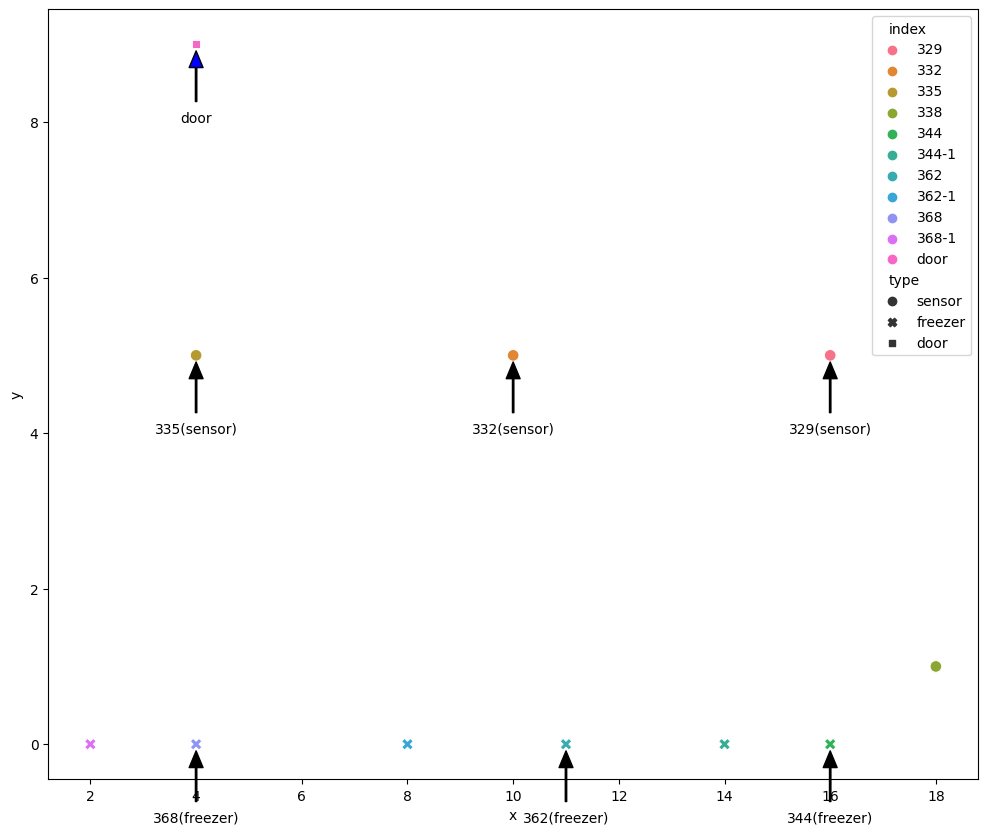

In [8]:
display_position(pos)

# Mapping

## melt id to columns

In [38]:
df0 = df_freezer.copy()['gw_time']
for _id in df_freezer['freezer_id'].unique():
    df_tmp = df_freezer[df_freezer['freezer_id'] == _id]
    df_tmp.reset_index(drop = True)
    df_tmp.drop(columns= ['freezer_id'], inplace= True)
    df_tmp.columns = ['gw_time']+[x+'_'+str(_id) for x in df_freezer.columns if x not in ['freezer_id','gw_time']]
    df0 = pd.merge(df0, df_tmp, on = 'gw_time', how = 'outer')

melted_freezer = df0

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_14120\1092712872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['freezer_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_14120\1092712872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['freezer_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_14120\1092712872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [39]:
df0 = df_sensor.copy()['gw_time']
for _id in df_sensor['sensor_id'].unique():
    df_tmp = df_sensor[df_sensor['sensor_id'] == _id]
    df_tmp.reset_index(drop = True)
    df_tmp.drop(columns= ['sensor_id'], inplace= True)
    df_tmp.columns = ['gw_time']+[x+'_'+str(_id) for x in df_sensor.columns if x not in ['sensor_id','gw_time']]
    df0 = pd.merge(df0, df_tmp, on = 'gw_time', how = 'outer')

melted_sensor = df0

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_14120\1020320345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['sensor_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_14120\1020320345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['sensor_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_14120\1020320345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [40]:
melted_df = pd.merge_asof(
    left=melted_sensor.sort_values(by="gw_time"),
    right=melted_freezer.sort_values(by="gw_time"),
    on="gw_time",
    direction="forward",
    tolerance=pd.Timedelta("30 second"),
    allow_exact_matches=False,
    suffixes=("_freezer", "_sensor"),
)
melted_df.drop_duplicates(inplace= True, ignore_index= True)

## delta temperture (dT)

In [41]:
# melted_df['dT_335'] = melted_df['temperature_335'] - melted_df.temperature_335.shift(1).fillna(melted_df['temperature_335'][0])
# melted_df['dT_332'] = melted_df['temperature_332'] - melted_df.temperature_332.shift(1).fillna(melted_df['temperature_332'][0])
# melted_df['dT_329'] = melted_df['temperature_329'] - melted_df.temperature_329.shift(1).fillna(melted_df['temperature_329'][0])

for _id in sensor_id:
    melted_df['dT_'+str(_id)] =  melted_df['temperature_'+str(_id)] - melted_df['temperature_'+str(_id)].shift(1).fillna(melted_df['temperature_'+str(_id)][0])


## correlation between condition of freezer and temperature, humidity
- 온도가 올라가면 freezer를 가동한다, 가동하면 온도가 떨어진다. -> freezer 가동과 온도의 상관관계 오히려 양수로 나옴
- fan을 가동하면 humidity가 떨어진다.

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = melted_df.copy()
scaler = MinMaxScaler()
float_columns = ['temperature','humidity','dT']
for _id in sensor_id:
    for col in float_columns:
        scaled_df[str(col)+'_'+str(_id)] = scaler.fit_transform(scaled_df[str(col)+'_'+str(_id)].values.reshape(-1,1))

In [43]:
sensor_cols = ['temperature','humidity']
freezer_cols = ['fan_run','freez_run','operation']
corr0 = scaled_df[[x+'_'+str(_id) for x in freezer_cols for _id in freezer_id] + [x+'_'+str(_id) for x in sensor_cols for _id in sensor_id]].corr()

<AxesSubplot: title={'center': 'correlation between condition of freezer and temperature'}>

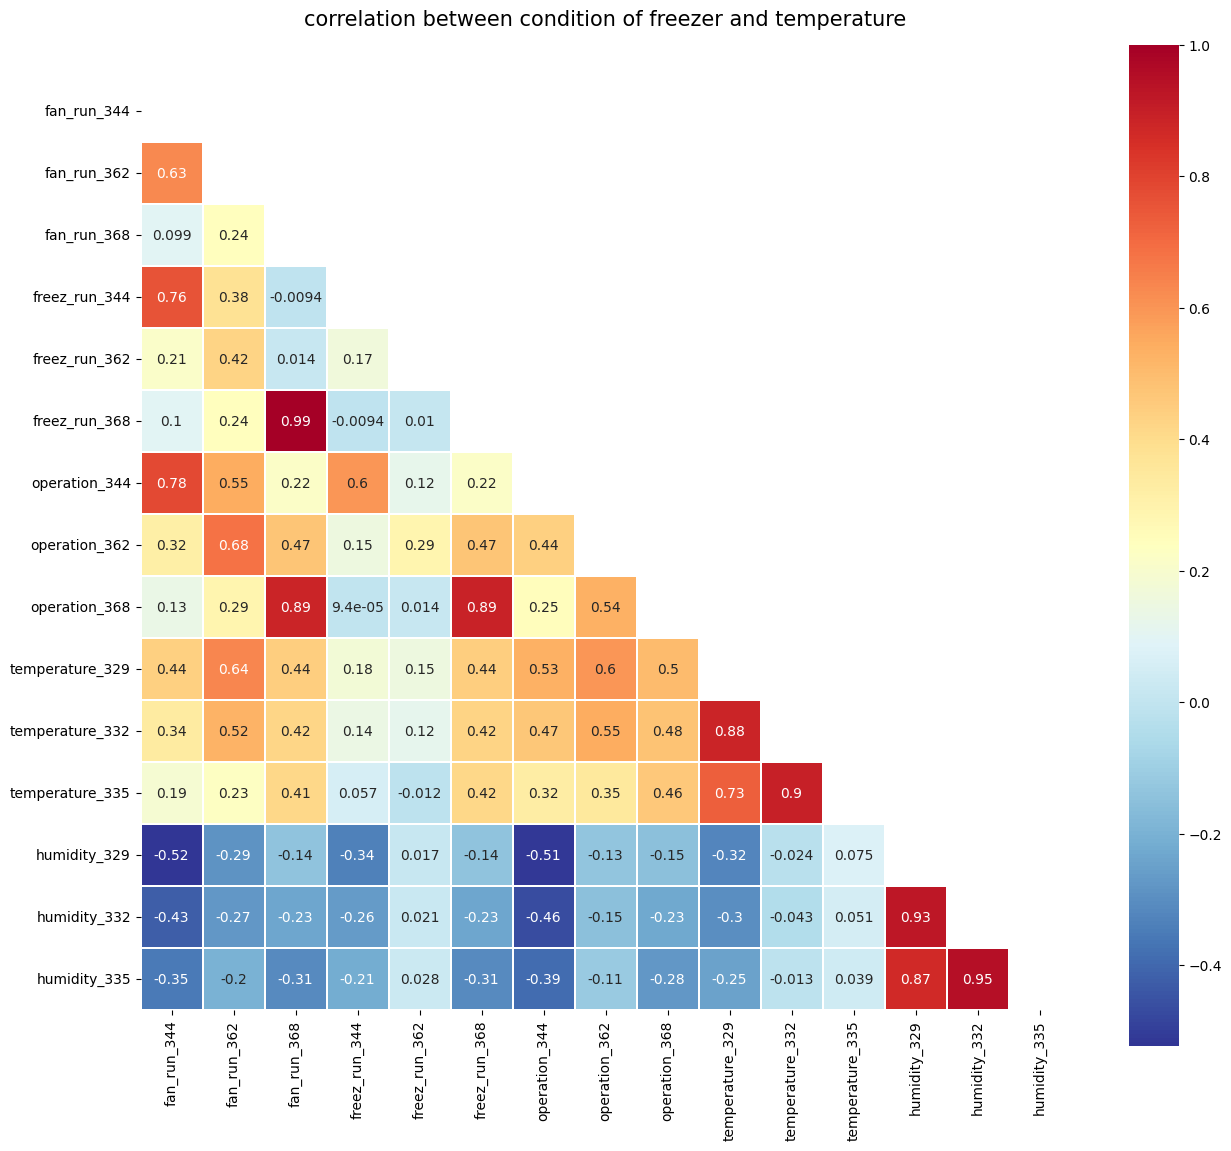

In [44]:
mask = np.zeros_like(corr0, dtype= np.bool_)
mask[np.triu_indices_from(mask)] = True

colormap = plt.cm.PuBu
plt.figure(figsize=(15, 13))
plt.title("correlation between condition of freezer and temperature", y = 1.05, size = 15)
sns.heatmap(corr0, linewidths = 0.1,mask= mask, vmax = 1.0,square = True, cmap = 'RdYlBu_r', linecolor = "white", annot = True, annot_kws = {"size" : 10})



In [45]:
corr_cols = [str(f_col)+'_'+str(_id) for f_col in df_freezer.columns if f_col not in ['freezer_id','gw_time','status','run_time'] for _id in freezer_id] + [str(s_col)+'_'+str(_id) for s_col in ['temperature','humidity','dT'] for _id in sensor_id]
scaled_df1 = scaled_df[corr_cols]
corr1 = scaled_df1.corr()

<AxesSubplot: title={'center': 'correlation between condition of freezer and temperature'}>

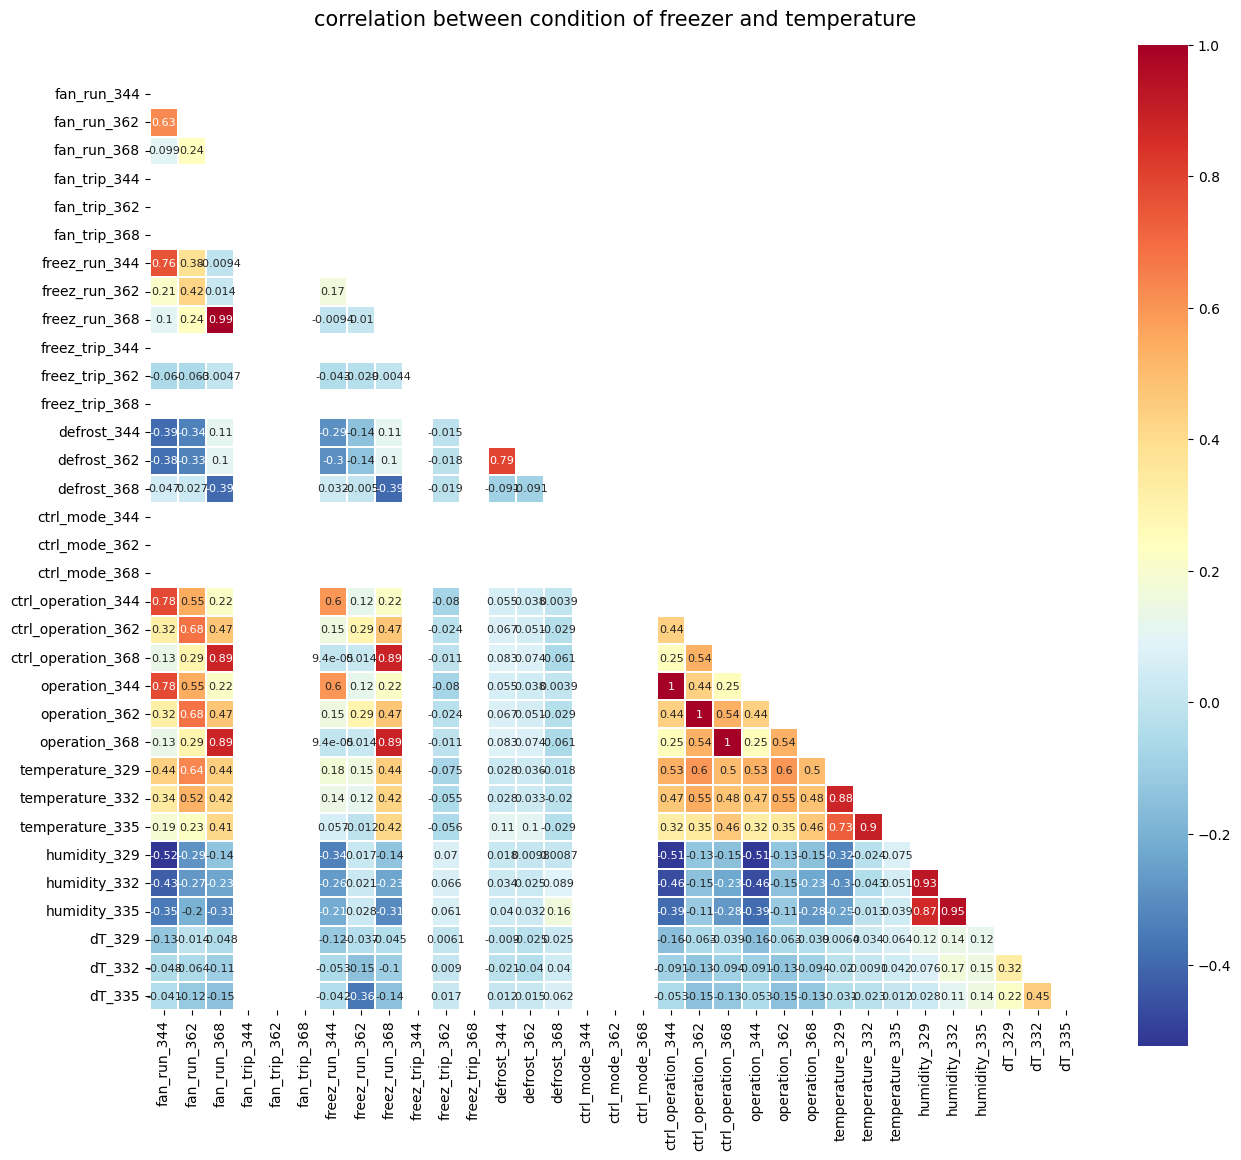

In [46]:
mask = np.zeros_like(corr1, dtype= np.bool_)
mask[np.triu_indices_from(mask)] = True

colormap = plt.cm.PuBu
plt.figure(figsize=(15, 13))
plt.title("correlation between condition of freezer and temperature", y = 1.05, size = 15)
sns.heatmap(corr1, linewidths = 0.1,mask= mask, vmax = 1.0,square = True, cmap = 'RdYlBu_r', linecolor = "white", annot = True, annot_kws = {"size" : 8})


In [47]:
corr1.dropna().columns

Index(['fan_run_344', 'fan_run_362', 'fan_run_368', 'fan_trip_344',
       'fan_trip_362', 'fan_trip_368', 'freez_run_344', 'freez_run_362',
       'freez_run_368', 'freez_trip_344', 'freez_trip_362', 'freez_trip_368',
       'defrost_344', 'defrost_362', 'defrost_368', 'ctrl_mode_344',
       'ctrl_mode_362', 'ctrl_mode_368', 'ctrl_operation_344',
       'ctrl_operation_362', 'ctrl_operation_368', 'operation_344',
       'operation_362', 'operation_368', 'temperature_329', 'temperature_332',
       'temperature_335', 'humidity_329', 'humidity_332', 'humidity_335',
       'dT_329', 'dT_332', 'dT_335'],
      dtype='object')

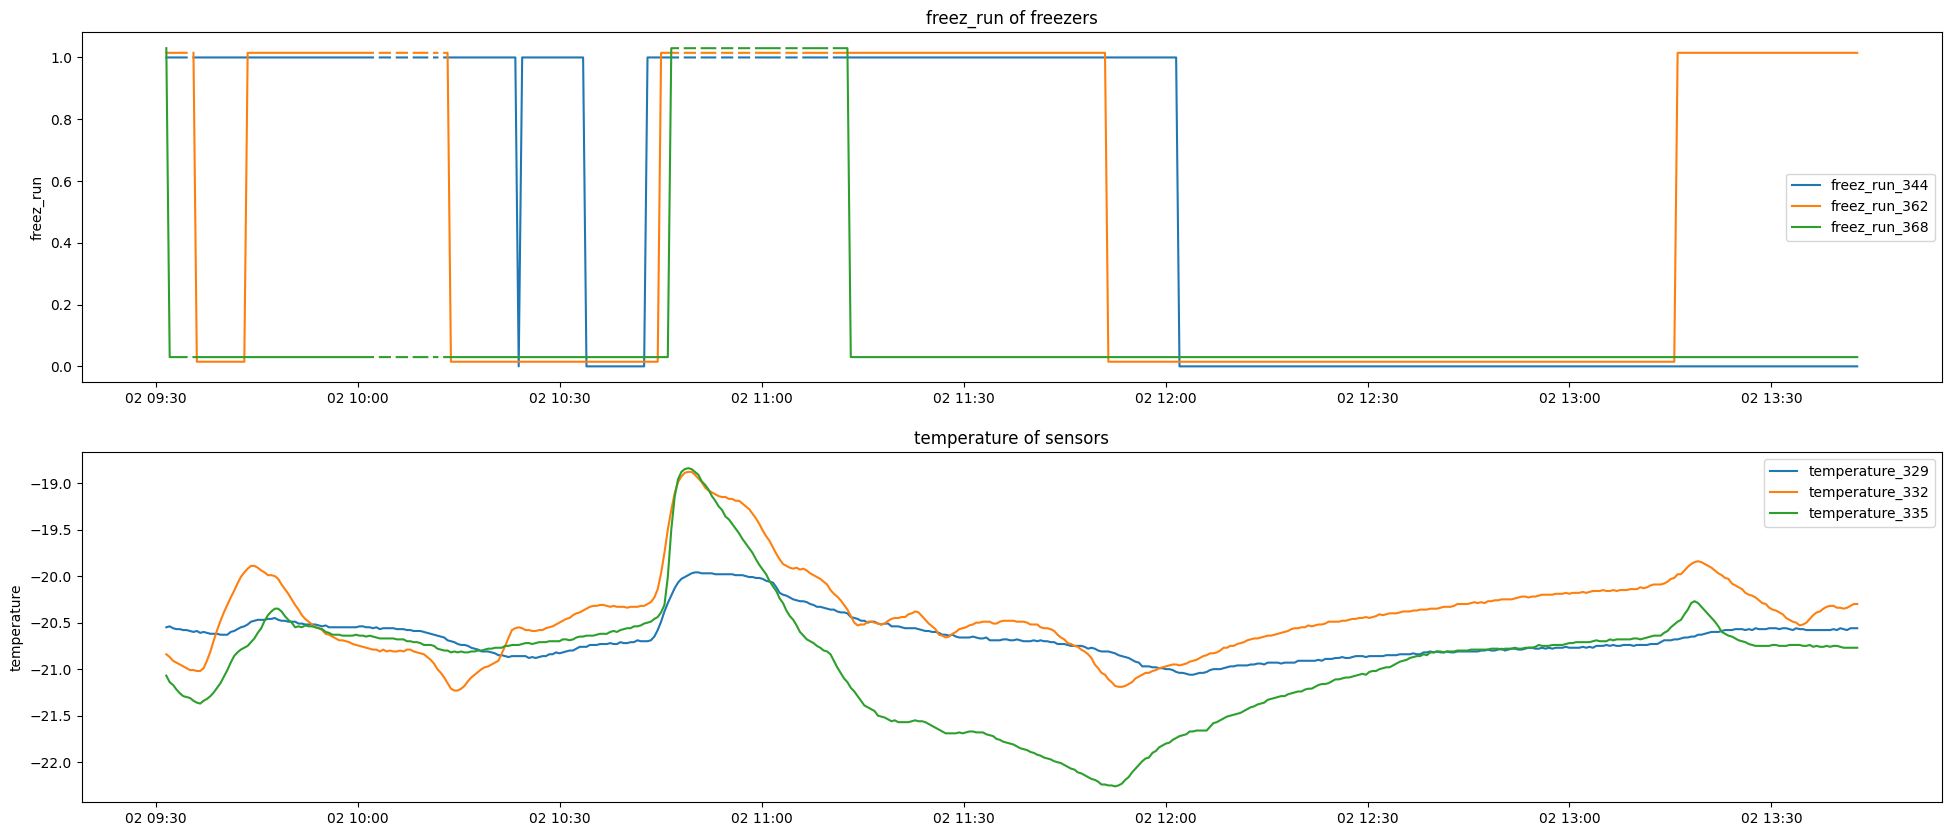

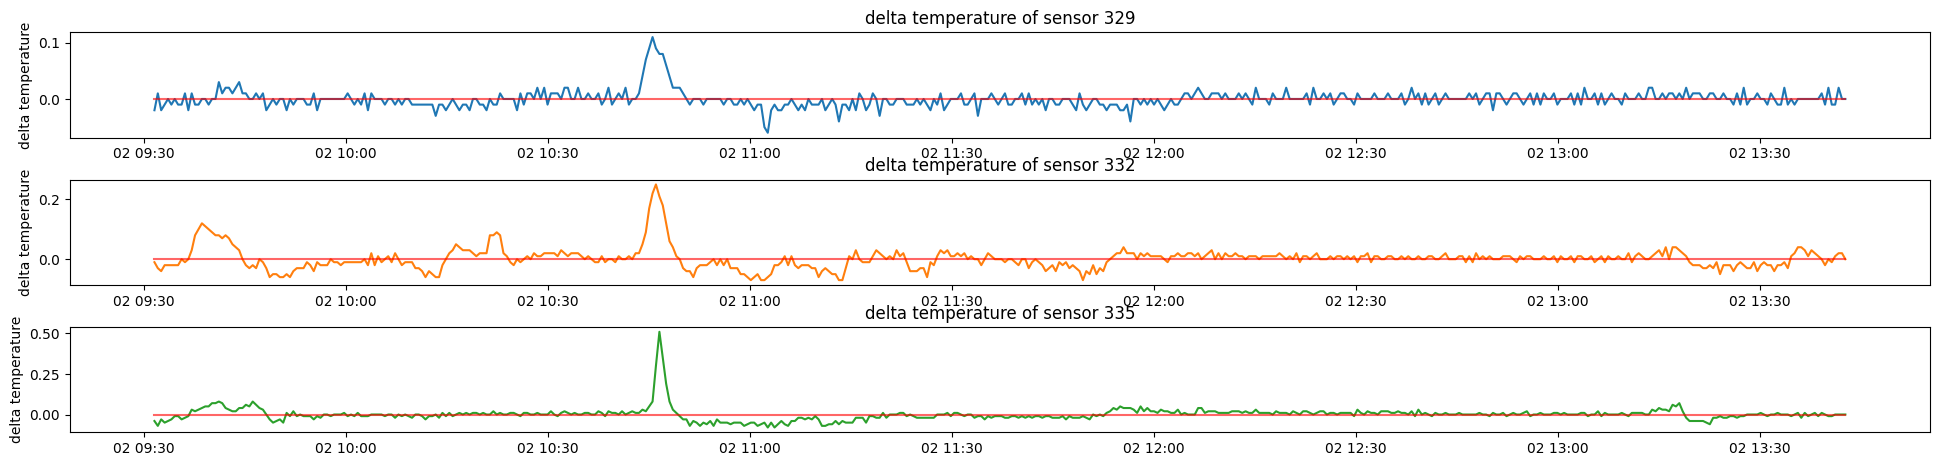

In [48]:
test_figure = melted_df[4000:4500]
plt.figure(figsize = (24,10))

plt.subplot(2,1,1)
plt.title("freez_run of freezers")
w = 0
for _id in freezer_id:
    plt.plot(test_figure['gw_time'],test_figure['fan_run'+'_'+str(_id)]+w, label = 'freez_run'+'_'+str(_id),alpha = 1)
    w+= 0.015
plt.ylabel('freez_run')
plt.legend()

plt.subplot(2,1,2)
plt.title('temperature of sensors')
for _id in sensor_id:
    plt.plot(test_figure['gw_time'],test_figure['temperature'+'_'+str(_id)], label = 'temperature'+'_'+str(_id),alpha = 1)
plt.ylabel('temperature')
plt.legend()
plt.show()

i = 1
colors = ['tab:blue','tab:orange','tab:green']
plt.figure(figsize = (24,5))
for _id in sensor_id:
    plt.subplot(3,1,i)
    plt.title('delta temperature of sensor '+str(_id), loc= 'center')
    plt.plot(test_figure['gw_time'],test_figure['dT'+'_'+str(_id)], label = 'dT'+'_'+str(_id),alpha = 1, color = colors[i-1])
    plt.plot(test_figure['gw_time'], [0]*len(test_figure), color = 'r', alpha = 0.6)
    plt.ylabel('delta temperature')
    i+=1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
plt.show()

# 간단한 모델 만들기

In [49]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

## Input Dataset

In [35]:
data = melted_df.copy()
data = data[[col for col in melted_df.columns if col[:-4] in ['humidity','temperature','fan_run','freez_run','operation','dT']]]
data.index = melted_df['gw_time']

In [27]:
def reshape_dataset(self, df: pd.DataFrame) -> np.array:
    # y 컬럼을 데이터프레임의 맨 마지막 위치로 이동
    if "y" in df.columns:
        df = df.drop(columns=["y"]).assign(y=df["y"])
    else:
        raise KeyError("Not found target column 'y' in dataset.")
    
    # shape 변경
    dataset = df.values.reshape(df.shape)
    return dataset

ForecastLSTM.reshape_dataset = reshape_dataset

## Sequential Dataset


In [37]:
for entry in enumerate(['A', 'B', 'C']):
    print(entry)

(0, 'A')
(1, 'B')
(2, 'C')


In [ ]:
def split_sequences(
    self, dataset: np.array, seq_len: int, steps: int, single_output: bool
) -> tuple:

    # feature와 y 각각 sequential dataset을 반환할 리스트 생성
    X, y = list(), list()
    # sequence length와 step에 따라 sequential dataset 생성
    for i, _ in enumerate(dataset):
        idx_in = i + seq_len
        idx_out = idx_in + steps
        if idx_out > len(dataset):
            break
        seq_x = dataset[i:idx_in, :-1]
        if single_output:
            seq_y = dataset[idx_out - 1 : idx_out, -1]
        else:
            seq_y = dataset[idx_in:idx_out, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


ForecastLSTM.split_sequences = split_sequences